### 代码实现

In [62]:
! pip install torchinfo

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [63]:
# 导入必要的库，torchinfo用于查看模型结构
import torch
import torch.nn as nn
from torchinfo import summary

### 模型定义

In [64]:
# 定义LeNet-5模型（适配32×32输入）
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 卷积层1：输入1个通道，输出6个通道，卷积核大小为5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # 卷积层2：输入6个通道，输出16个通道，卷积核大小为5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # 全连接层1：输入16x5x5个节点，输出120个节点
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        # 全连接层2：输入120个节点，输出84个节点
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # 输出层：输入84个节点，输出10个节点
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))                   # 卷积+Relu激活
        x = nn.functional.max_pool2d(x, kernel_size=2)  # 最大池化
        x = torch.relu(self.conv2(x))                   # 卷积+Relu激活
        x = nn.functional.max_pool2d(x, kernel_size=2)  # 最大池化
        x = x.view(-1, 16 * 5 * 5)                      # 将多维张量展平为一维张量
        x = torch.relu(self.fc1(x))                     # 全连接+Relu激活
        x = torch.relu(self.fc2(x))                     # 全连接+Relu激活
        x = self.fc3(x)                                 # 输出层
        return x

### 网络结构

In [65]:
# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
# input_size参数是一个元组，包含4个值，分别表示(批量大小, 通道数, 高, 宽)
# 这里LeNet用于处理32x32的单通道灰度图像，batch_size可以任意指定（如1），所以input_size=(1, 1, 32, 32)
# batch_size是影响输出形状(output shape),不影响模型参数量(param)
summary(LeNet5(), input_size=(1, 1, 32, 32))
# 输出结构
# Layer: 层级定义
# Output Shape : 输出的数据结构
# Param : 当前层的参数
# 输出的7个值含义如下：
# 1. Total params: 模型中所有参数的总数（可训练+不可训练），这里是61706
# 2. Trainable params: 可训练参数的数量（会被优化器更新），这里是61706
# 3. Non-trainable params: 不可训练参数数量（不会被优化器更新），这里是0
# 4. Total mult-adds: 前向传播时的乘加运算总量，衡量计算量，单位是百万次（MB=百万次，不是兆字节）
# 5. Input size (MB): 输入张量占用的内存大小（以MB为单位）
# 6. Forward/backward pass size (MB): 前向和反向传播过程中所有中间激活值占用的内存总量
# 7. Params size (MB): 所有参数占用的内存大小
# 8. Estimated Total Size (MB): 估算的总内存占用（输入+激活+参数）

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30

### 模型训练

use device is  cpu


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0   Loss: 2.7228   Accuracy: 0.6319  
Epoch: 1   Loss: 2.3345   Accuracy: 0.8569  
Epoch: 2   Loss: 1.7574   Accuracy: 0.9478  
Epoch: 3   Loss: 1.5640   Accuracy: 0.9567  
Epoch: 4   Loss: 1.4437   Accuracy: 0.9690  
Epoch: 5   Loss: 1.3535   Accuracy: 0.9747  
Epoch: 6   Loss: 1.2998   Accuracy: 0.9791  
Epoch: 7   Loss: 1.2298   Accuracy: 0.9724  
Epoch: 8   Loss: 1.1928   Accuracy: 0.9819  
Epoch: 9   Loss: 1.1559   Accuracy: 0.9788  


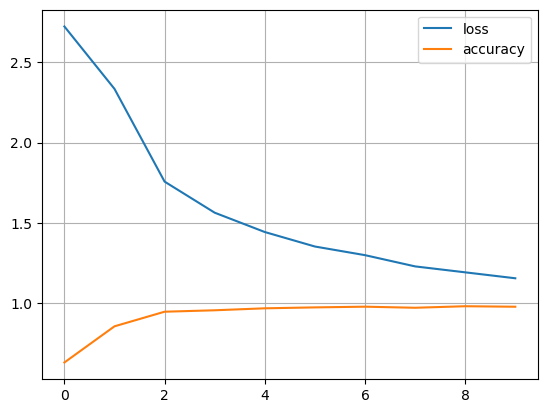

Final Accuracy: 0.9788


In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm  # tqdm用于显示进度条并评估任务时间开销
import numpy as np
import sys
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR


# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("use device is",device)
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
# Adam结果(精确度等)会更稳定一些,但是训练速度会比较慢
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# 使用SGD+scheduler训练速度会最快
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 定义余弦学习率调度器，T_max=5 表示每 5 个 epoch 完成一个周期(从最大值到最小值就是一个周期,从最小值到最大值也算一个周期)
# 周期特性：若训练周期超过 T_max，学习率会重新上升并循环变化（需结合 T_max 和总训练周期数设置）
# 默认行为：若训练总周期数 ≤ T_max，学习率将单调递减至 eta_min
# 优势：
#   避免局部最优：学习率的周期性变化有助于模型跳出局部最小值，探索更广阔的参数空间。
#   精细收敛：训练后期学习率降低，使模型能够更精确地收敛到全局最优解附近(所以最好多几个周期,这里时间因素,只训练2个周期)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.0001)


# 设置数据变换
# transforms.Compose用于将多个变换操作串联起来
transform = transforms.Compose(
    [
        transforms.Pad(2),  # 每个图像边缘padding 2像素，使图像从28×28变为32×32
        transforms.ToTensor(),  # 把图片或转换为PyTorch的FloatTensor，并且归一化到[0,1]区间
        # 此时模型输入分布在[0.0,1.0] 使用 Normalize：模型输入分布被调整为均值≈0，标准差≈1，更符合模型期望的输入分布
        # 深度学习模型通常在标准化数据（均值≈0，标准差≈1）上表现更好，主要原因是：
        #   数值稳定性：避免因输入值过大或过小导致的梯度爆炸 / 消失问题
        #   加速收敛：标准化后的数据能使梯度更新更均匀，减少训练时间
        #   特征分布对齐：不同通道的特征可能具有不同的分布，标准化后可消除这种差异
        # 这里为了简化,方便理解主流程,所以暂时忽略
        # transforms.Normalize(mean=(train_mean,), std=(train_std,))
    ]
)

# 加载训练数据
train_dataset = datasets.MNIST(root="../data/mnist/", train=True, download=True, transform=transform)
# 加载测试数据
test_dataset = datasets.MNIST(root="../data/mnist/", train=False, download=True, transform=transform)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


# 训练函数
def train(model, device, train_loader, optimizer,scheduler, loss_history):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()               # 清除梯度
        outputs = model(inputs)             # 训练
        loss = criterion(outputs, labels)   # 计算损失函数
        loss.backward()                     # 反向传播
        optimizer.step()                    # 更新参数
        total_loss += loss.item()           # 记录训练集loss
    # 记录训练集损失
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    scheduler.step() # 更新学习率

# 测试函数
def test(model, device, test_loader, acc_history):
    total_correct = 0
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 将数据转移到指定计算资源设备上
            inputs,labels = inputs.to(device),labels.to(device)
            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
    # 记录测试集准确率
    acc_history.append(total_correct / len(test_dataset))  # 将准确率加入准确率历史记录列表


# 设置epoch数并开始训练
num_epochs = 10  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []  # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs)):
    train(model,device, train_loader, optimizer, scheduler, loss_history)
    test(model,device, test_loader, acc_history)
    # 打印 <8.4f : 左对齐，总宽度 8，保留 4 位小数。
    tqdm.write(f"Epoch: {epoch:<3} Loss: {loss_history[-1]:<8.4f} Accuracy: {acc_history[-1]:<8.4f}")
    


# 使用Matplotlib绘制损失和准确率的曲线图
plt.plot(loss_history, label="loss")
plt.plot(acc_history, label="accuracy")
plt.grid()
plt.legend()
plt.show()

# 输出准确率
print("Final Accuracy:", acc_history[-1])

In [67]:
# 保存模型
torch.save(model.state_dict(), "lenet5_mnist.pth")